In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from tqdm import tqdm_notebook as tqdm

from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet

In [3]:
#url = 'https://raw.githubusercontent.com/raidake/SC1015-Data-Science-Real-or-Fake-Job-Ads/main/reallyCleanData.csv?token=GHSAT0AAAAAABTT3LBZJC7RJ7R4TTIRPZQWYS2VQLA'
#tD = pd.read_csv(url)

tD = pd.read_csv("reallyCleanData.csv")

In [4]:
tD['text'] = tD['company_profile'] + ' ' + tD['description'] + ' ' + tD['requirements'] 

In [5]:
del tD['telecommuting']
del tD['has_company_logo']
del tD['has_questions']
del tD['minSalary']
del tD['maxSalary']
del tD['haveSalary']
del tD['title']
del tD['location']
del tD['department']
del tD['company_profile']
del tD['description']
del tD['requirements']
del tD['benefits']
del tD['employment_type']
del tD['required_experience']
del tD['required_education']
del tD['industry']
del tD['function']
del tD['job_id']
del tD['country']
del tD['state']
del tD['city']

In [6]:
tD.head()

,fraudulent,text
0,0,"We're Food52, and we've created a groundbreaki..."
1,0,"90 Seconds, the worlds Cloud Video Production ..."
2,0,Valor Services provides Workforce Solutions th...
3,0,Our passion for improving quality of life thro...
4,0,SpotSource Solutions LLC is a Global Human Cap...


CLEANING TEXT FOR SPACY AND TFIDF

In [7]:
cD = tD.replace(np.nan, '', regex=True)
def standardize_text(df, text_field):
    df2 = df.copy(deep=True)
    df2[text_field] = df[text_field].str.replace(r"http\S+", "", regex=True)
    df2[text_field] = df[text_field].str.replace(r"http", "", regex=True)
    df2[text_field] = df[text_field].str.replace(r"@\S+", "", regex=True)
    df2[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ", regex=True)
    df2[text_field] = df[text_field].str.replace(r"@", "at", regex=True)
    df2[text_field] = df[text_field].str.lower()
    return df2
df_clean = standardize_text(cD, "text")

In [8]:
df_clean

,fraudulent,text
0,0,"we're food52, and we've created a groundbreaki..."
1,0,"90 seconds, the worlds cloud video production ..."
2,0,valor services provides workforce solutions th...
3,0,our passion for improving quality of life thro...
4,0,spotsource solutions llc is a global human cap...
...,...,...
17875,0,vend is looking for some awesome new talent to...
17876,0,weblinc is the e-commerce platform and service...
17877,0,we provide full time permanent positions for m...
17878,0,unspecified nemsia studios is looking for an e...


In [9]:
#del df_clean['tokens']
#del df_clean['lemm_tokens']

tD = df_clean.copy()

In [10]:
tD

,fraudulent,text
0,0,"we're food52, and we've created a groundbreaki..."
1,0,"90 seconds, the worlds cloud video production ..."
2,0,valor services provides workforce solutions th...
3,0,our passion for improving quality of life thro...
4,0,spotsource solutions llc is a global human cap...
...,...,...
17875,0,vend is looking for some awesome new talent to...
17876,0,weblinc is the e-commerce platform and service...
17877,0,we provide full time permanent positions for m...
17878,0,unspecified nemsia studios is looking for an e...


# REMOVE STOP WORDS LIKE 'and' , 'a', etc...

In [11]:
import nltk
nltk.download('stopwords')


stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\eisna\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
def get_simple_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# LEMMATIZE & TOKENIZE

In [13]:
lemmatizer = WordNetLemmatizer()

In [14]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
tD["tokens"] = tD["text"].apply(tokenizer.tokenize)
lemmatizer = WordNetLemmatizer()
obj = tD["tokens"]
listOfDFRows = obj.to_numpy().tolist()
len(listOfDFRows)

17880

In [15]:
import nltk
nltk.download('wordnet')

from nltk.corpus import stopwords
lemm_tokens = []
lemms = []
for i in range(len(listOfDFRows)):
    for words in listOfDFRows[i]:
        if words not in stopwords.words('english'):
            lemmas = lemmatizer.lemmatize(words.lower(), pos='v')
            lemms.append(lemmas)
    lemm_tokens.append(lemms)
    lemms = []
a = lemm_tokens
%store a

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\eisna\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Stored 'a' (list)


In [36]:
spacytD = df_clean.copy()
spacytD
del 

,fraudulent,text
0,0,"we're food52, and we've created a groundbreaki..."
1,0,"90 seconds, the worlds cloud video production ..."
2,0,valor services provides workforce solutions th...
3,0,our passion for improving quality of life thro...
4,0,spotsource solutions llc is a global human cap...
...,...,...
17875,0,vend is looking for some awesome new talent to...
17876,0,weblinc is the e-commerce platform and service...
17877,0,we provide full time permanent positions for m...
17878,0,unspecified nemsia studios is looking for an e...


In [43]:
import spacy
spacylemmatizer = spacy.load("en_core_web_sm", disable = ['parser','ner'])
spacytD['token'] = [spacylemmatizer(text) for text in df_clean.text]

In [44]:
spacytD

,fraudulent,text,token
0,0,"we're food52, and we've created a groundbreaki...","(we, 're, food52, ,, and, we, 've, created, a,..."
1,0,"90 seconds, the worlds cloud video production ...","(90, seconds, ,, the, worlds, cloud, video, pr..."
2,0,valor services provides workforce solutions th...,"(valor, services, provides, workforce, solutio..."
3,0,our passion for improving quality of life thro...,"(our, passion, for, improving, quality, of, li..."
4,0,spotsource solutions llc is a global human cap...,"(spotsource, solutions, llc, is, a, global, hu..."
...,...,...,...
17875,0,vend is looking for some awesome new talent to...,"(vend, is, looking, for, some, awesome, new, t..."
17876,0,weblinc is the e-commerce platform and service...,"(weblinc, is, the, e, -, commerce, platform, a..."
17877,0,we provide full time permanent positions for m...,"(we, provide, full, time, permanent, positions..."
17878,0,unspecified nemsia studios is looking for an e...,"(unspecified, nemsia, studios, is, looking, fo..."


In [16]:
tD = tD.assign(lemm_tokens=a)
tD.to_csv('tokenized.csv')

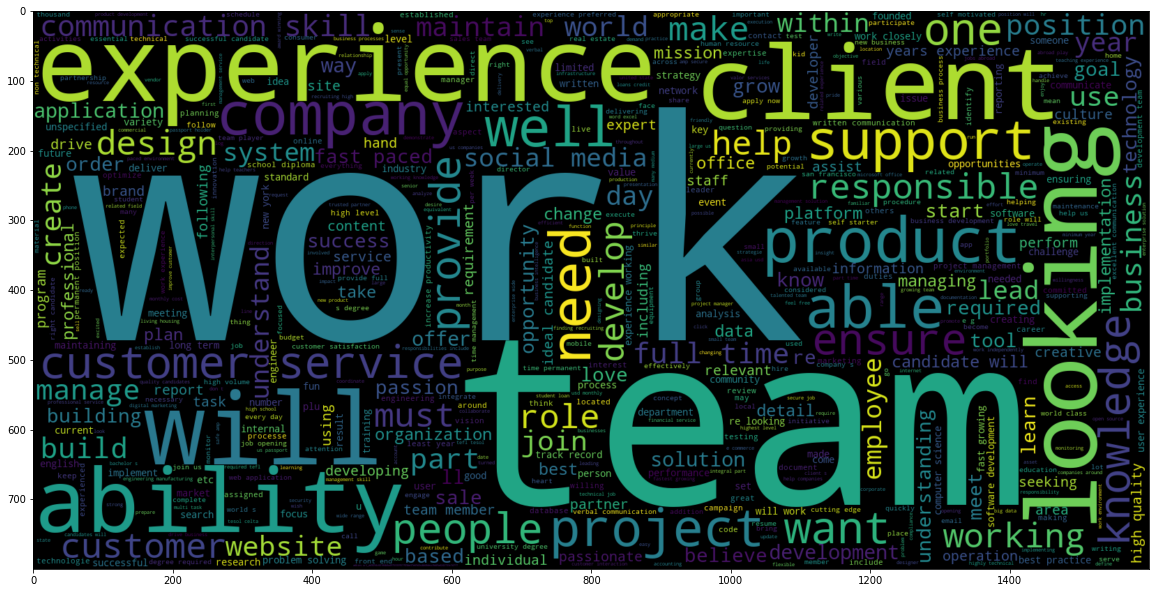

In [17]:
plt.figure(figsize = (20,20)) # Text that is not fraudulent(0)
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000).generate(" ".join(tD[tD.fraudulent == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

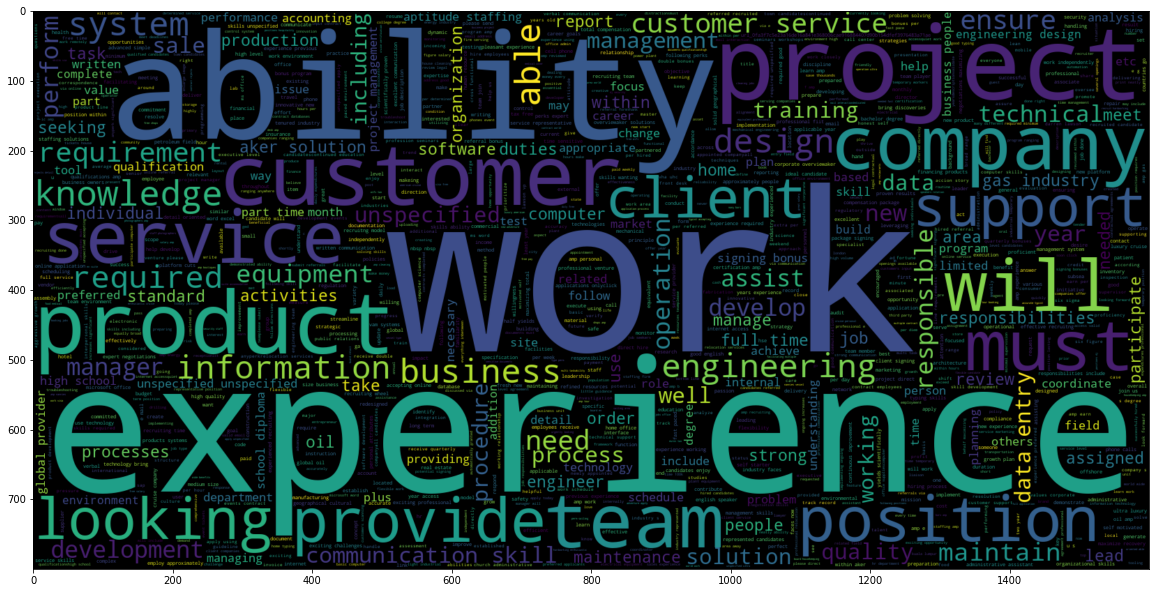

In [18]:
plt.figure(figsize = (20,20)) # Text that is fraudulent(1)
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000).generate(" ".join(tD[tD.fraudulent == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

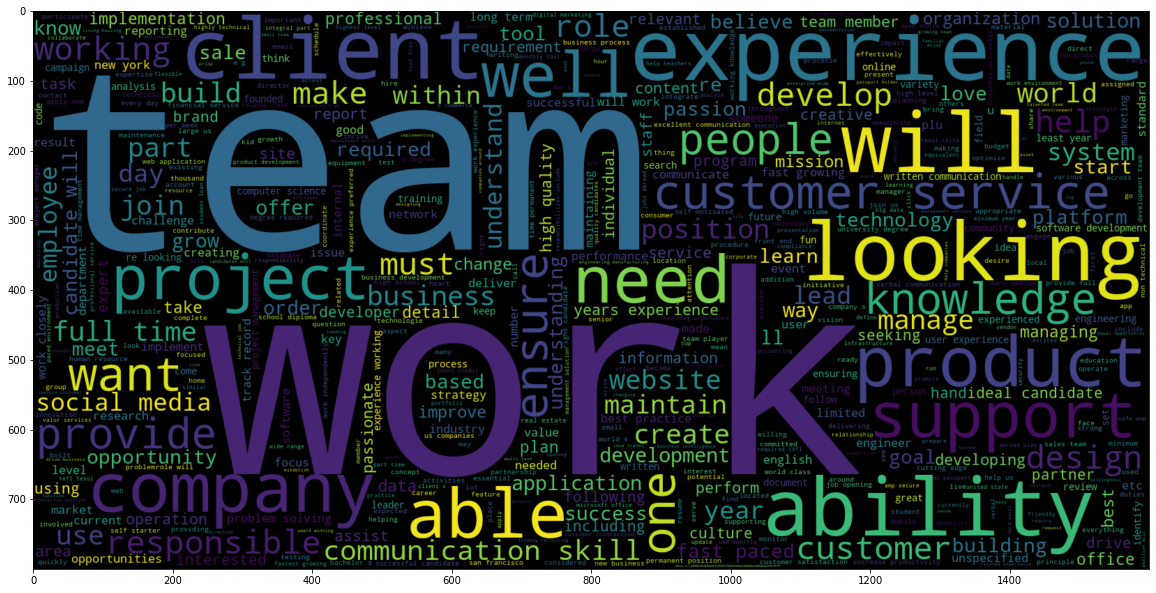

In [46]:
plt.figure(figsize = (20,20)) # Text that is not fraudulent(0)
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000).generate(" ".join(spacytD[spacytD.fraudulent == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

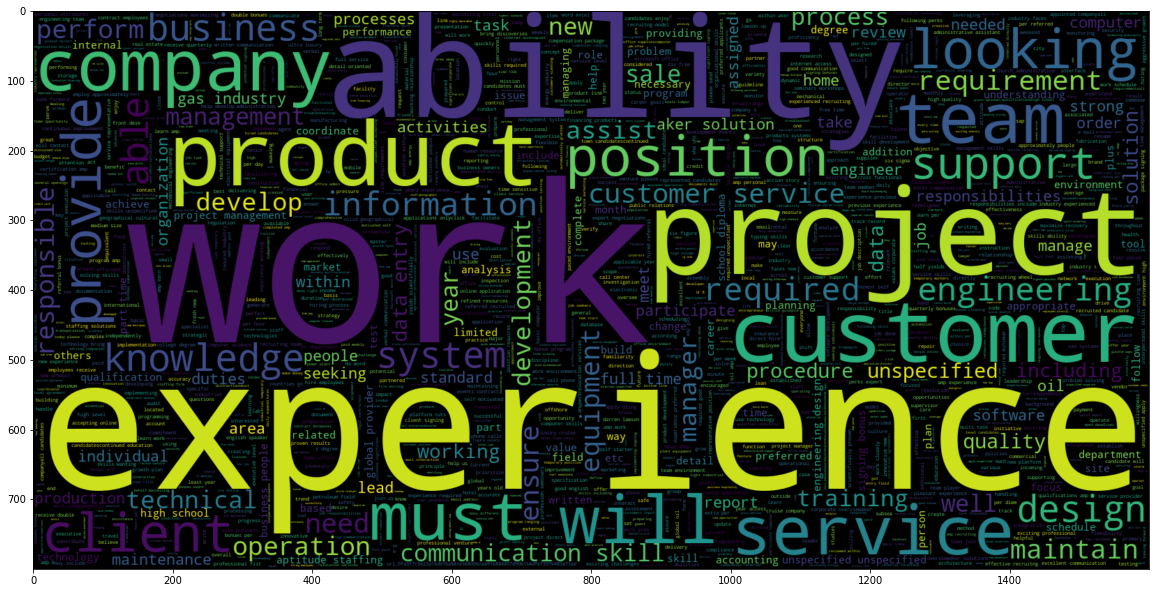

In [49]:
plt.figure(figsize = (20,20)) # Text that is not fraudulent(0)
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000).generate(" ".join(spacytD[spacytD.fraudulent == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

# MIGHT BE BETTER TO SPLIT INTO TRAINING / TEST SETS BEFORE VECTORIZATION

In [19]:
wordtokens = tD['lemm_tokens']



def dummy_fun(doc):
    return doc
tfidf = TfidfVectorizer(
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None)  
tfidf.fit(wordtokens)
wordtfidf = tfidf.transform(wordtokens)

In [55]:
spacytokens = spacytD['token']
tfidfS = TfidfVectorizer(
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None)

tfidfS.fit(spacytokens)
spacytfidf = tfidfS.transform(spacytokens)

In [56]:
spacytfidf

<17880x7171069 sparse matrix of type '<class 'numpy.float64'>'
	with 7171069 stored elements in Compressed Sparse Row format>

# Use elbow method

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters


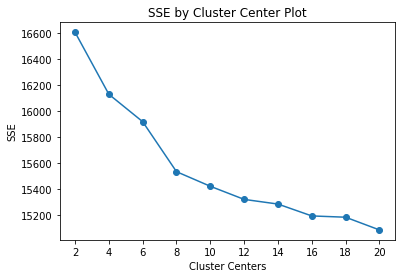

In [20]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(wordtfidf, 20)

In [21]:
clusters = MiniBatchKMeans(n_clusters=8, init_size=1024, batch_size=2048, random_state=20).fit_predict(wordtfidf)

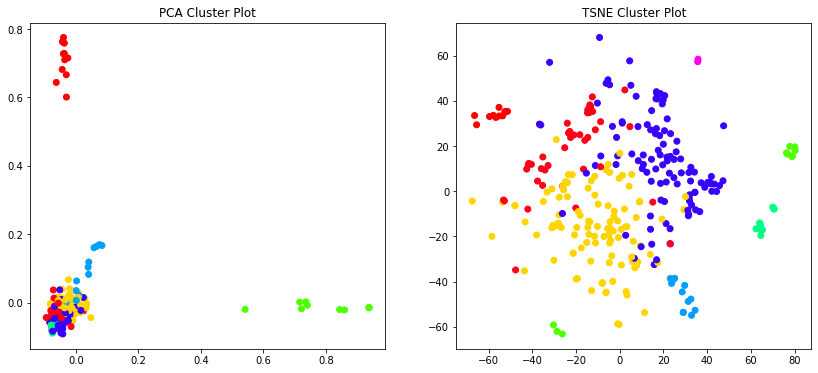

In [22]:
def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=3000, replace=False)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
plot_tsne_pca(wordtfidf, clusters)

In [23]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(wordtfidf, clusters, tfidf.get_feature_names(), 10)


Cluster 0
16,consultants,right,work,long,education,career,course,wish,apprenticeship

Cluster 1
skills,position,must,provide,company,customer,home,experience,work,service

Cluster 2
abroad,loan,usd,kid,teachers,passport,tefl,tesol,celta,get

Cluster 3
communications,service,increase,enterprise,solutions,process,productivity,document,mail,customer

Cluster 4
click,1500,engineer,redirect,technical,apply,manufacture,search,job,website

Cluster 5
engineer,data,software,project,development,web,team,experience,work,design

Cluster 6
news,per,week,deeper,digital,broadcaster,video,fail,conflict,shall

Cluster 7
campaign,experience,digital,work,team,business,social,media,market,sales


# Using KMeans (Approx. 200)

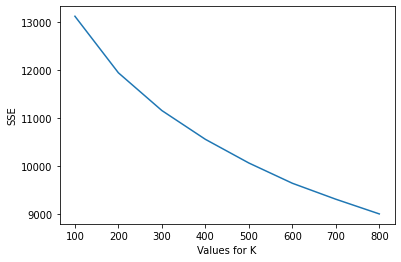

In [24]:
from sklearn.cluster import KMeans
sse={}
for k in np.arange(100,900,100):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(wordtfidf)
    sse[k] = kmeans.inertia_
plt.plot(list(sse.keys()),list(sse.values()))
plt.xlabel('Values for K')
plt.ylabel('SSE')
plt.show();

In [25]:
kmeans = KMeans(n_clusters=200)
kmeans.fit(wordtfidf)
result = pd.concat([tD,pd.DataFrame(wordtfidf.toarray(),columns=tfidf.get_feature_names())],axis=1)
result['cluster'] = kmeans.predict(wordtfidf)

In [58]:
result[['fraudulent','text','cluster']]


,fraudulent,text,cluster
0,0,"we're food52, and we've created a groundbreaki...",47
1,0,"90 seconds, the worlds cloud video production ...",87
2,0,valor services provides workforce solutions th...,0
3,0,our passion for improving quality of life thro...,189
4,0,spotsource solutions llc is a global human cap...,77
...,...,...,...
17875,0,vend is looking for some awesome new talent to...,56
17876,0,weblinc is the e-commerce platform and service...,11
17877,0,we provide full time permanent positions for m...,177
17878,0,unspecified nemsia studios is looking for an e...,3


In [33]:
def df_column_uniquify(df):
    df_columns = df.columns
    new_columns = []
    for item in df_columns:
        counter = 0
        newitem = item
        while newitem in new_columns:
            counter += 1
            newitem = "{}{}".format(item, counter)
        new_columns.append(newitem)
    df.columns = new_columns
    return df


result = df_column_uniquify(result)



In [59]:
result1 = result[['fraudulent','text','cluster']]
result1

,fraudulent,text,cluster
0,0,"we're food52, and we've created a groundbreaki...",47
1,0,"90 seconds, the worlds cloud video production ...",87
2,0,valor services provides workforce solutions th...,0
3,0,our passion for improving quality of life thro...,189
4,0,spotsource solutions llc is a global human cap...,77
...,...,...,...
17875,0,vend is looking for some awesome new talent to...,56
17876,0,weblinc is the e-commerce platform and service...,11
17877,0,we provide full time permanent positions for m...,177
17878,0,unspecified nemsia studios is looking for an e...,3
